Code template for simple fully connected CNN for baseline:

In [1]:
import cv2
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

Using TensorFlow backend.


In [0]:
# preprocess reference_df, should probably save this as the csv instead
reference_df = pd.read_csv('./drive/My Drive/BT4222/dress_info_0to10k.csv')
reference_df['name'] = reference_df['name'].apply(lambda x: x + '.jpg')
reference_df['vote'] = reference_df['vote'].str.extract('(\d+)', expand=False)\
                                            .astype(int).fillna(0)\
                                            .transform(np.log)
#                                             .transform(lambda x: (x - x.min()) / (x.max() - x.min())) # minmax scale
reference_df.fans = reference_df.fans.fillna(0.0)
reference_df.tags = reference_df.tags.fillna('np.nan').apply(eval)

In [0]:
pd.DataFrame(history.history).plot.line()

TODO: Partition a test set (or simply scrape another few k) and evaluate with sklearn metrics

# Clustering of tags - [link](https://www.reddit.com/r/IdleHeroes/comments/b3nga6/guide_early_game_e3_guide_v4/)

In [0]:
tag_counts = pd.Series(reference_df.tags.fillna('-').apply(list).sum()).value_counts()#[:10] # top 10 most popular tags

Everyday                     2966
summer                       2886
Chic                         2557
spring                       2229
fall                         2014
Summer                       1501
winter                       1391
Casual                        930
Bohemian                      896
Romantic                      707
Elegant                       687
Dinner Date                   626
Classic                       593
Brunch                        581
Vintage                       416
Casual Party                  376
Cocktail                      360
Other                         334
Trendy                        328
Lunch Date                    313
Going Out With Friends        296
Dinner Party                  292
Comfortable                   278
Work                          236
Eclectic                      217
Photo Shoot                   214
Holiday Party                 213
Urban                         208
Fashion Show                  201
Art Opening   

In [0]:
vc = pd.Series(reference_df.tags.fillna('-').apply(list).sum()).value_counts() #if you remove all those tags with only 1 instance, number of tags reduce from 801 to 294


In [0]:
vc[vc<23].sum() / vc.sum()

0.05000476841402549

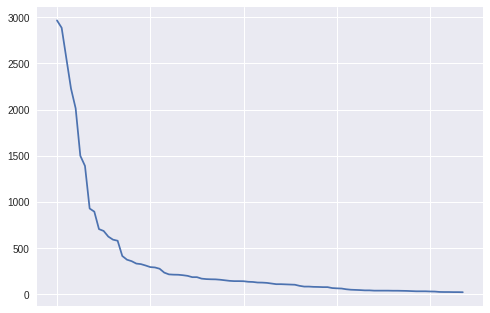

In [0]:
vc[vc>23].plot()

In [0]:
tags_to_keep = vc[vc>23].index.tolist()

In [0]:
len(tags_to_keep)

88

# NLP part

In [0]:
tag_lists = pd.Series(reference_df.tags.fillna('-').apply(list).sum()).unique()
print(tag_lists.shape)

(801,)


In [0]:
list_tag = tag_lists[0] + "."
count=1

for i in range(len(tag_lists)-1):
  string = tag_lists[i+1]
  list_tag = list_tag + " " + string + "."
  count+=1
  
print(list_tag)
print("Number of tags: "+ str(count))

Chic. Blind Date. spring. Bohemian. Dinner Date. Everyday. Summer. Androgynous. Casual Party. fall. Rocker. Clubbing. 50s. Wedding. Other. Retro. Movie night. Brunch. summer. Romantic. Cocktail. 12. The Fair. Casual. winter. Shopping. inspiration. flippy in floral. Elegant. Fashion Show. Eclectic. 80s. Vintage. Vacation. Classic. Going Out With Friends. Trendy. 60s. Work. Dinner Party. Graduation. cute. so chic. Sexy. Lunch Date. 90s. Baby Shower. Art Opening. nice. Punk. BBQ Party. lace. Holiday Party. Preppy. First Date. Picnic. sunday breeze romantic. Bachelorette Party. Birthday. Beach. white. Formal. Wine Tasting. School. Comfortable. Traveling. 70s. Boot Style. Valentine's Day. yellow. Outdoor. Business Casual. Photo Shoot. Girls Night Out. comfortable party shoes. dress. Prom. Denim. Urban. Romantic Dinner. Goth. mmmmmmmmmmmmmmmm. Farmer's Market. prom. bohemian. Work Happy Hour. Theatre/Opera/Symphony. Maternity. Hippie. gray. DIY. diy. Kipling Make Happy. sakura. legal. red. N

In [0]:
doc1 = nlp(list_tag)

In [0]:
spacy_token = []
count = 0

for sent in doc1.sents:
  spacy_token.append(sent)
  count+=1
  
print("Number of tags: "+ str(count))

Number of tags: 747


In [0]:
print(spacy_token[0], spacy_token[1])
spacy_token[0].similarity(spacy_token[1])

Chic. Blind Date.


0.5804782403849037

In [0]:
similarity_dic = {}

for i in range(len(spacy_token)):
  token1 = spacy_token[i]
  similarity_scores = []
  
  for j in range(len(spacy_token)):
    token2 = spacy_token[j]
    score = token1.similarity(token2)
    similarity_scores.append(score)
  
  similarity_dic[str(token1)] = similarity_scores

In [0]:
similarity_df = pd.DataFrame.from_dict(similarity_dic, orient='index')
column_names = similarity_dic.keys()
similarity_df.columns = column_names
print(similarity_df.shape)

(747, 747)

In [0]:
similarity_df.head(10)


,Chic.,Blind Date.,spring.,Bohemian.,Dinner Date.,Everyday.,Summer.,Androgynous.,Casual Party.,fall.,...,snickers.,baseball cap.,w-o the boots.,hippie.,tea dress.,leather bag.,quirky.,gatsby.,nice combo.,blue sneakers dress le.... crop top.
Chic.,1.000000,0.580478,0.335163,0.654607,0.484479,0.380541,0.545060,0.598591,0.514622,0.337767,...,0.419467,0.217423,0.256799,0.510488,0.309808,0.209356,0.473172,0.507208,0.306378,0.370020
Blind Date.,0.580478,1.000000,0.521863,0.644053,0.744942,0.555672,0.597887,0.555069,0.667692,0.473366,...,0.390616,0.416708,0.378089,0.554111,0.485807,0.494092,0.480091,0.528959,0.484566,0.473366
spring.,0.335163,0.521863,1.000000,0.524792,0.502503,0.607430,0.652445,0.447529,0.409602,0.750933,...,0.361324,0.566238,0.394323,0.636587,0.536998,0.577260,0.522763,0.668069,0.543105,0.539744
Bohemian.,0.654607,0.644053,0.524792,1.000000,0.610712,0.696629,0.700867,0.768760,0.573616,0.525532,...,0.497166,0.402423,0.262842,0.565031,0.383341,0.376464,0.571034,0.518019,0.483987,0.422462
Dinner Date.,0.484479,0.744942,0.502503,0.610712,1.000000,0.605498,0.611421,0.457154,0.682885,0.456386,...,0.244915,0.470772,0.307536,0.407888,0.440095,0.428701,0.266793,0.466957,0.317886,0.316826
Everyday.,0.380541,0.555672,0.607430,0.696629,0.605498,1.000000,0.603718,0.604476,0.494586,0.520510,...,0.316744,0.290712,0.196344,0.531146,0.291246,0.380270,0.491781,0.423303,0.398524,0.298558
Summer.,0.545060,0.597887,0.652445,0.700867,0.611421,0.603718,1.000000,0.602737,0.451844,0.612506,...,0.505938,0.465445,0.294268,0.598346,0.465646,0.437753,0.490454,0.583463,0.471144,0.414503
Androgynous.,0.598591,0.555069,0.447529,0.768760,0.457154,0.604476,0.602737,1.000000,0.469154,0.421175,...,0.442105,0.241359,0.159680,0.472843,0.285282,0.276461,0.584707,0.426721,0.436455,0.387885
Casual Party.,0.514622,0.667692,0.409602,0.573616,0.682885,0.494586,0.451844,0.469154,1.000000,0.388344,...,0.221682,0.297683,0.244384,0.381996,0.357514,0.295628,0.313920,0.388585,0.293356,0.331685
fall.,0.337767,0.473366,0.750933,0.525532,0.456386,0.520510,0.612506,0.421175,0.388344,1.000000,...,0.434455,0.508376,0.444263,0.597898,0.452782,0.551412,0.467185,0.586472,0.468110,0.488113


In [0]:
similarity_df.columns

Index(['Chic.', 'Blind Date.', 'spring.', 'Bohemian.', 'Dinner Date.',
       'Everyday.', 'Summer.', 'Androgynous.', 'Casual Party.', 'fall.',
       ...
       'snickers.', 'baseball cap.', 'w-o the boots.', 'hippie.', 'tea dress.',
       'leather bag.', 'quirky.', 'gatsby.', 'nice combo.',
       'blue sneakers dress le.... crop top.'],
      dtype='object', length=747)

NLP part END

# The shitszzs

In [0]:
for i in range(len(tags)):
  tag = tags[i]
  try:
    if not isinstance(eval(tag), list):
      print(tag)
  except:
    print('Bad ' + str(i))

In [0]:
reference_df.head(5)

,name,fans,fave,tags,vote
0,1164104-Inner+Beauty-vipme-dress-vipme-bracele...,31856.0,57 favorites,"[Chic, Blind Date, spring]",5.934894
1,1102069-Keep+her+wild-floral-gypsan-dress.jpg,170.0,71 favorites,"[Bohemian, Dinner Date, spring]",5.932245
2,1113840-Black+maxi+dress-black-delacy-dress.jpg,640.0,50 favorites,"[Bohemian, Everyday, Summer]",5.564520
3,1138091-Cos+I%E2%80%99m+Loving+It-white-shirt-...,569.0,65 favorites,"[Androgynous, Casual Party, fall]",5.693732
4,1110854-Rock+and+Roll+Queen-black-leather-self...,29687.0,31 favorites,"[Rocker, Clubbing, spring]",5.971262


In [0]:
tags_column = reference_df.tags.dropna().apply(lambda x:pd.Series(x)).stack().reset_index(level=1,drop=True)

In [0]:
#Making the tags as individual columns

df_out = reference_df.assign(**pd.get_dummies(tags_column)[tags_to_keep].sum(level=0)) #https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list
df_out.head(5)

,name,fans,fave,tags,vote,Everyday,summer,Chic,spring,fall,...,Business,nice,Sneaker,Bridal Shower,DIY,dresses,Sports,white,Wine Tasting,Baby Shower
0,1164104-Inner+Beauty-vipme-dress-vipme-bracele...,31856.0,57 favorites,"[Chic, Blind Date, spring]",5.934894,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1102069-Keep+her+wild-floral-gypsan-dress.jpg,170.0,71 favorites,"[Bohemian, Dinner Date, spring]",5.932245,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1113840-Black+maxi+dress-black-delacy-dress.jpg,640.0,50 favorites,"[Bohemian, Everyday, Summer]",5.564520,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1138091-Cos+I%E2%80%99m+Loving+It-white-shirt-...,569.0,65 favorites,"[Androgynous, Casual Party, fall]",5.693732,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1110854-Rock+and+Roll+Queen-black-leather-self...,29687.0,31 favorites,"[Rocker, Clubbing, spring]",5.971262,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
df_out.columns.values

In [0]:
df_out.shape

(10000, 805)

In [0]:
!pip install kmodes
!pip install --upgrade kmodes

    100% |████████████████████████████████| 4.9MB 6.7MB/s 
yellowbrick 0.9.1 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.2 which is incompatible.
imbalanced-learn 0.4.3 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.2 which is incompatible.
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3
Requirement already up-to-date: kmodes in /usr/local/lib/python3.6/dist-packages (0.9)


In [0]:
from kmodes.kmodes import KModes

In [0]:
df_features = df_out.iloc[:,5:]
df_features.shape

NameError: ignored

In [0]:
df_features_array = df_features.dropna().values # 18 pictures have no tags
df_features_array.shape

NameError: ignored

In [0]:
for i in range(4,8):
  km = KModes(n_clusters=i, init='Huang', n_init=20, verbose=0) #https://stackoverflow.com/questions/41827660/reveal-k-modes-cluster-features
  clusters = km.fit_predict(df_features_array)
  score = silhouette_score(df_features_array, clusters, metric='euclidean', random_state=12345)
  print('For {} clusters, the score is {}'.format(i, score))

In [0]:
km = KModes(n_clusters=5, init='Huang', n_init=20, verbose=0) #https://stackoverflow.com/questions/41827660/reveal-k-modes-cluster-features
clusters = km.fit_predict(df_features_array)

In [0]:
clusters.shape

(9982,)

In [0]:
results = pd.DataFrame(df_features_array, columns=df_features.columns)
results['cluster'] = clusters

In [0]:
results.cluster.value_counts()

3    2868
4    2217
2    2007
1    1501
0    1389
Name: cluster, dtype: int64

In [0]:
top_cluster_tags = [results.drop(columns=['cluster'])\
                            .columns[results.drop(columns=['cluster'])\
                                              [results.cluster == i].sum() > 100]
                    for i in range(5)]

In [0]:
[top_cluster_tags[0][top_cluster_tags[0].isin(top_cluster_tags[i])] for i in range(1,5)]

[Index(['Everyday', 'Chic', 'Casual', 'Elegant'], dtype='object'),
 Index(['Everyday', 'Chic', 'Casual', 'Dinner Date'], dtype='object'),
 Index(['Everyday', 'Chic', 'Casual', 'Elegant', 'Dinner Date'], dtype='object'),
 Index(['Everyday', 'Chic', 'Casual', 'Elegant', 'Dinner Date'], dtype='object')]

In [0]:
results_ = df_features.drop(columns=['Everyday', 'Chic', 'Casual']).dropna()

In [0]:
from sklearn.metrics import silhouette_score

In [0]:
# drop everyday, chic, casual
km = KModes(n_clusters=5, init='Huang', n_init=20, verbose=0) #https://stackoverflow.com/questions/41827660/reveal-k-modes-cluster-features
clusters = km.fit_predict(results_.values)
score = silhouette_score(results_.values, clusters, metric='euclidean', random_state=12345)
print('For {} clusters, the score is {}'.format(5, score))

For 5 clusters, the score is 0.26837145703213633


In [0]:
pd.Series(clusters).value_counts()

2    2868
3    2218
1    2009
0    1501
4    1386
dtype: int64

In [0]:
top_cluster_tags_ = [results_.columns[results_.loc[results_.index[pd.Series(clusters) == i]].sum() > 100] for i in range(5)]
[top_cluster_tags_[0][top_cluster_tags_[0].isin(top_cluster_tags_[i])] for i in range(1,5)]

[Index(['Classic'], dtype='object'),
 Index(['Elegant', 'Classic'], dtype='object'),
 Index(['Elegant', 'Classic'], dtype='object'),
 Index(['Elegant'], dtype='object')]

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
pca = PCA(3)

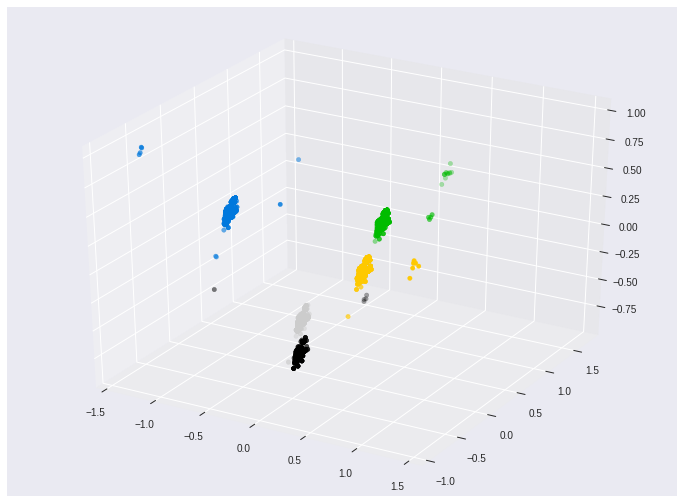

In [0]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
plot_columns = pca.fit_transform(results_)
ax.scatter(plot_columns[:,1],
           plot_columns[:,0],
           plot_columns[:,2],
           s=20, c=pd.Series(clusters), cmap=plt.cm.nipy_spectral,
           depthshade=True)
#fig = plt.figure(1, figsize=(12, 9))
#plt.clf()
#ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
# Turn the dummified df into two columns with PCA


# Plot based on the two dimensions, and shade by cluster label
plt.show()

# This will give the mode of each variable for each cluster
#km.cluster_centroids_

In [0]:
np.sum(pca.explained_variance_) # TOH

0.6535639322244966

In [0]:
(results_.sum(axis=1) == 0).sum() # After dropping Everyday, Chic, Casual, there are still tags for every row

0

In [0]:
style_map = dict(pd.Series(clusters).value_counts().items())
reference_df = reference_df.dropna(subset=['tags']).reset_index(drop=True)

In [0]:
reference_df['style_factor'] = pd.Series(map(lambda x: style_map[x], clusters)).apply(np.log1p)

In [0]:
reference_df['favorites'] = reference_df.fave.str.split(' ').apply(lambda x: x[0]).astype(int).apply(np.log1p)

In [0]:
reference_df['fans'] = reference_df.fans.apply(np.log1p)

In [0]:
from sklearn.preprocessing import scale

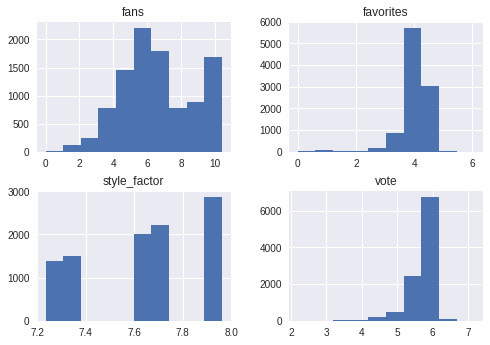

In [0]:
reference_df[['fans', 'vote', 'style_factor', 'favorites']].hist();

In [0]:
reference_df['popularity'] = ((reference_df.vote + reference_df.style_factor + reference_df.favorites) / (reference_df.fans+1)).apply(np.log)

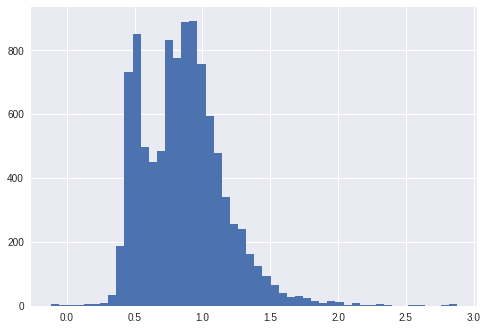

In [0]:
reference_df.popularity.hist(bins=50); # pretty normal, good for linear regression

In [0]:
reference_df.to_csv('./drive/My Drive/BT4222/preprocessed_df_for_cnn.csv')

# CNN Training

In [6]:
import os

In [16]:
df = pd.read_csv('./combine_10.csv', index_col=0)
orig = pd.read_csv('./dress_info_0to10k.csv')
cropped = os.listdir('./cropped/')

df.index = orig.name.apply(lambda x: x+'.jpg')
df = df[df.index.isin(cropped)]
tags_column = df['0'].apply(eval).apply(lambda x:pd.Series(x)).stack().reset_index(level=1,drop=True)
final = pd.get_dummies(tags_column).sum(level=0)

In [19]:
final = final.reset_index()

In [25]:
y_col = final.drop(columns=['name']).columns.tolist()
x_col = 'name'

Resize cropped images

In [18]:
for f in cropped:
    img = cv2.imread('cropped/'+f)
    img = cv2.resize(img, (150, 500))
    cv2.imwrite('resized/'+f, img)

In [26]:
img_size = (150, 500)
train_data_dir = 'resized/'
batch_size = 16 # mini-batch training

# stream input images for training and validation
train_datagen = ImageDataGenerator(
    rescale = 1./255, # shouldn't change, to improve convergence by converting pixel scale to 0-1
    # the below parameters applies some random transformations to training images
    horizontal_flip = True,
    rotation_range=10,
    fill_mode = "nearest",
    zoom_range = 0.1,
    height_shift_range = 0.1,
    validation_split = 0.1 # use 10% (i.e. 1k images) for validation
)

In [27]:
train_generator = train_datagen.flow_from_dataframe(
    final,
    directory = train_data_dir,
    x_col = x_col, y_col = y_col,
    target_size = img_size,
    batch_size = batch_size, 
    class_mode = "other",
    subset = 'training',
    seed = 12345
)

validation_generator = train_datagen.flow_from_dataframe(
    final,
    directory = train_data_dir,
    x_col = x_col, y_col = y_col,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = "other",
    subset = 'validation',
    seed = 12345,
)

Found 8646 images.
Found 960 images.


In [31]:
del model # just in case

In [32]:
model = Sequential()
# model.add(BatchNormalization(input_shape=(299, 299, 3))) # normalize images values for better convergence
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 500, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(48, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (5, 5), activation='relu'))
# model.add(MaxPooling2D()) # reduces the number of training parameters, but reduces accuracy

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vector
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))

model.add(Dense(len(y_col), activation='sigmoid')) 

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 498, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 249, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 247, 48)       13872     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 123, 48)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 121, 64)       27712     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 60, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 65280)             0         
__________

In [34]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint("./baseline_cnn_cropped_3layer.h5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)
early = EarlyStopping(monitor='val_acc', 
                      min_delta=0,
                      patience=10,
                      verbose=1,
                      mode='auto')

# Train the model 
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    epochs = 25,
    callbacks = [checkpoint, early],
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size,
)

Epoch 1/25
540/540 [==============================] - 437s 810ms/step - loss: 0.1094 - acc: 0.9670 - val_loss: 0.1113 - val_acc: 0.9641

Epoch 00001: val_acc improved from -inf to 0.96405, saving model to ./baseline_cnn_cropped_3layer.h5
Epoch 2/25
540/540 [==============================] - 320s 592ms/step - loss: 0.1047 - acc: 0.9689 - val_loss: 0.1083 - val_acc: 0.9657

Epoch 00002: val_acc improved from 0.96405 to 0.96566, saving model to ./baseline_cnn_cropped_3layer.h5
Epoch 3/25
540/540 [==============================] - 318s 589ms/step - loss: 0.1041 - acc: 0.9690 - val_loss: 0.1085 - val_acc: 0.9680

Epoch 00003: val_acc improved from 0.96566 to 0.96802, saving model to ./baseline_cnn_cropped_3layer.h5
Epoch 4/25
540/540 [==============================] - 319s 591ms/step - loss: 0.1038 - acc: 0.9689 - val_loss: 0.1097 - val_acc: 0.9657

Epoch 00004: val_acc did not improve from 0.96802
Epoch 5/25
540/540 [==============================] - 337s 624ms/step - loss: 0.1033 - acc: 0

In [47]:
from sklearn.metrics import classification_report, precision_recall_curve, auc, precision_score

In [37]:
val_preds = model.predict_generator(validation_generator,
                                    steps = validation_generator.samples // validation_generator.batch_size)

In [42]:
validation_generator.data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

In [46]:
print(classification_report(validation_generator.data, val_preds >= 0.5, 
                            target_names=y_col))

                        precision    recall  f1-score   support

                   50s       0.00      0.00      0.00         8
                   60s       0.00      0.00      0.00        17
                   70s       0.00      0.00      0.00         7
                   80s       0.00      0.00      0.00         5
                   90s       0.00      0.00      0.00        10
     None_of_the_above       0.00      0.00      0.00         0
        amusement park       0.00      0.00      0.00        10
           androgynous       0.00      0.00      0.00         3
           anniversary       0.00      0.00      0.00        14
           art opening       0.00      0.00      0.00        16
           baby shower       0.00      0.00      0.00         3
    bachelorette party       0.00      0.00      0.00         1
                 basic       0.00      0.00      0.00        14
             bbq party       0.00      0.00      0.00         5
                 beach       0.00      

C:\Users\Hong Jie\Anaconda3\envs\dl_gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Hong Jie\Anaconda3\envs\dl_gpu\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Hong Jie\Anaconda3\envs\dl_gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [53]:
precision_score(validation_generator.data, val_preds >= 0.5, average='micro')

0.23932926829268292